# Train a VAE on L1000 Data

In [2]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf


In [4]:
def remove_moa(df):
    pipes = ['CDK inhibitor|glycogen synthase kinase inhibitor',
         'AKT inhibitor|mTOR inhibitor',
             'EGFR inhibitor|protein tyrosine kinase inhibitor',
             'benzodiazepine receptor agonist|HDAC inhibitor',
            'dihydroorotate dehydrogenase inhibitor|PDGFR tyrosine kinase receptor inhibitor']    
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [5]:
data_splits = ["train", "valid", "test", "complete"]
data_dict = load_data(data_splits, dataset="L1000")


/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
# Prepare data for training
meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_id').reindex(index=data_dict['train']['pert_id']).reset_index().drop('pert_id',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_id').reindex(index=data_dict['valid']['pert_id']).reset_index().drop('pert_id',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [9]:
print(train_features_df.shape)
train_features_df.head(3)

(89599, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.74578,-0.007757,-0.063908,-0.115210,0.83776,-0.80023,-0.25787,-0.621180,-0.53313,-0.260430,...,-0.458550,0.51684,2.86550,-0.152210,-0.907810,1.47600,-0.42918,-0.81612,0.28533,0.37183
1,-0.29710,-0.180930,0.482090,-0.337130,-0.47045,-0.44483,0.38475,-0.566390,0.27726,0.000645,...,0.008161,-0.33238,-0.20174,-0.605390,0.024792,0.60759,0.41555,0.50640,0.23908,-0.23696
2,-0.75812,-0.283820,0.594330,0.089136,-0.85230,-0.78754,0.20291,0.018564,-0.22745,-0.839810,...,0.289560,0.16598,0.54440,-0.053607,0.439350,0.42920,-0.37040,-0.51931,-0.21799,-1.29360


In [10]:
print(valid_features_df.shape)
valid_features_df.head(3)

(11208, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.534400,0.552700,0.000000,-0.95760,-0.3264,-0.25560,0.00000,0.00000,1.88250,1.86290,...,5.22050,-0.96970,-1.133800,-1.079700,-2.29810,0.8493,0.29560,0.84640,0.19020,-0.47540
1,-0.029159,0.039928,0.045024,0.26740,-1.0234,0.58926,0.57561,0.60793,0.33281,-0.65153,...,-0.25789,0.46169,0.022211,-0.035998,0.67575,2.2909,0.24359,-0.14676,-0.84884,-0.16919
2,0.365290,-1.311300,-0.153500,0.72378,-1.1094,-0.38681,1.05910,0.12169,-1.01300,0.83094,...,-0.22982,-0.21314,-0.088198,0.527700,0.49855,-1.3877,1.00980,-0.21835,0.16329,-0.79029


In [11]:
print(test_features_df.shape)
test_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.28158,1.6038,-1.58650,-0.41677,-2.34260,3.12320,-0.10233,1.62600,0.115840,-0.000233,...,-0.49069,-1.14930,-0.16539,0.49864,1.077800,1.66230,-1.66900,-0.49738,0.51629,1.08940
1,0.77369,1.0853,0.75758,1.04900,1.18270,0.69324,-0.43503,-0.88949,-0.075833,0.208990,...,0.10747,0.97814,0.85407,0.10528,-0.370430,0.89069,-0.26969,-0.98646,-1.07350,0.48240
2,0.63079,1.9072,-1.65190,0.26266,0.68423,-0.38400,1.63160,0.78741,0.732920,-2.431700,...,-1.83770,-0.56064,0.93692,0.96585,-0.036786,1.35430,2.15870,-0.28158,0.53111,-0.46053


In [12]:
print(complete_features_df.shape)
complete_features_df.head(3)

(118050, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,4.26410,0.057249,-2.13930,-0.22178,-0.37656,1.91380,0.065576,-0.86895,-0.10227,0.00000,...,5.246200,0.057058,-1.25620,-0.025255,0.168860,-1.639100,0.68510,-0.41942,1.71610,-0.47234
1,-0.38221,0.304310,-0.99592,-0.67083,-0.64824,0.62161,0.889530,0.20376,0.19481,-0.45637,...,0.206690,-0.010866,-0.87206,-0.223750,0.074144,0.093595,0.32667,1.04810,-0.50518,-0.61832
2,-0.57171,-0.755000,-0.71011,0.42889,0.27261,0.31436,-1.545800,0.64195,-0.87685,0.00000,...,-0.005612,1.194500,0.17111,0.334370,-1.089300,-0.114640,0.30483,-0.24947,-0.42835,1.58500


In [13]:

encoder_architecture = [500]
decoder_architecture = [500]


In [14]:

L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=65,
    batch_size=512,
    encoder_batch_norm=True,
    epochs=180,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)

L1000_vae.compile_vae()


In [15]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/180
175/175 [==============================] - 6s 27ms/step - loss: 1636.7054 - recon: 1436.5485 - kl: 26.4142 - val_loss: 1303.2134 - val_recon: 1270.5283 - val_kl: 32.6851
Epoch 2/180
175/175 [==============================] - 4s 23ms/step - loss: 1286.0336 - recon: 1237.2594 - kl: 31.5644 - val_loss: 1255.6327 - val_recon: 1218.5848 - val_kl: 37.0480
Epoch 3/180
175/175 [==============================] - 4s 23ms/step - loss: 1213.6971 - recon: 1171.8341 - kl: 36.3265 - val_loss: 1190.8198 - val_recon: 1152.5284 - val_kl: 38.2912
Epoch 4/180
175/175 [==============================] - 4s 23ms/step - loss: 1187.3869 - recon: 1133.0817 - kl: 40.7761 - val_loss: 1157.2114 - val_recon: 1113.0200 - val_kl: 44.1914
Epoch 5/180
175/175 [==============================] - 4s 23ms/step - loss: 1152.4980 - recon: 1104.0531 - kl: 44.6399 - val_loss: 1137.4421 - val_recon: 1090.2770 - val_kl: 47.1652
Epoch 6/180
175/175 [==============================] - 4s 22ms/step - loss: 1134.4376 - re

Epoch 92/180
175/175 [==============================] - 4s 23ms/step - loss: 894.7817 - recon: 813.9426 - kl: 81.7663 - val_loss: 916.3361 - val_recon: 834.6848 - val_kl: 81.6516
Epoch 93/180
175/175 [==============================] - 4s 23ms/step - loss: 897.4796 - recon: 813.9844 - kl: 81.7969 - val_loss: 916.0858 - val_recon: 834.2748 - val_kl: 81.8111
Epoch 94/180
175/175 [==============================] - 4s 23ms/step - loss: 895.6912 - recon: 812.9587 - kl: 81.7602 - val_loss: 916.2231 - val_recon: 834.7278 - val_kl: 81.4953
Epoch 95/180
175/175 [==============================] - 4s 23ms/step - loss: 895.0827 - recon: 813.5695 - kl: 81.7848 - val_loss: 916.0203 - val_recon: 833.9268 - val_kl: 82.0935
Epoch 96/180
175/175 [==============================] - 4s 22ms/step - loss: 894.1999 - recon: 813.3886 - kl: 81.7810 - val_loss: 916.0775 - val_recon: 834.4867 - val_kl: 81.5909
Epoch 97/180
175/175 [==============================] - 4s 22ms/step - loss: 892.2478 - recon: 812.1707 -

In [20]:
    L1000_vae.vae

In [21]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df


,loss,recon,kl,val_loss,val_recon,val_kl
0,1462.962280,1436.548462,26.414171,1303.213379,1270.528320,32.685120
1,1268.823853,1237.259399,31.564404,1255.632690,1218.584839,37.047974
2,1208.160522,1171.834106,36.326515,1190.819824,1152.528442,38.291153
3,1173.857788,1133.081665,40.776134,1157.211426,1113.020020,44.191422
4,1148.692993,1104.053101,44.639874,1137.442139,1090.276978,47.165245
...,...,...,...,...,...,...
175,881.588135,799.737854,81.850037,907.371460,825.525940,81.845398
176,881.518921,799.755371,81.763893,906.170837,824.737854,81.433014
177,881.319946,799.569031,81.750900,906.773926,825.280090,81.493774
178,881.111877,799.276978,81.834816,907.166016,826.007507,81.158470


In [22]:
history_df.to_csv('twolayer_training_vanilla_leaveOut.csv')

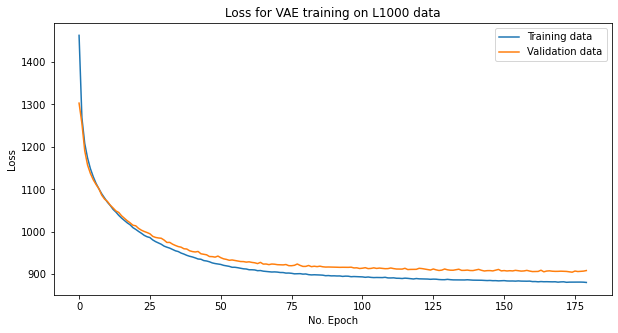

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
plt.ylabel("MSE + KL Divergence")
plt.ylabel("Loss")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [24]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

369/369 [==============================] - 1s 2ms/step - loss: 913.6094 - recon: 831.3920 - kl: 82.2170


[913.609375, 831.3920288085938, 82.21698760986328]

In [25]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

3132.3373975705076

<AxesSubplot:>

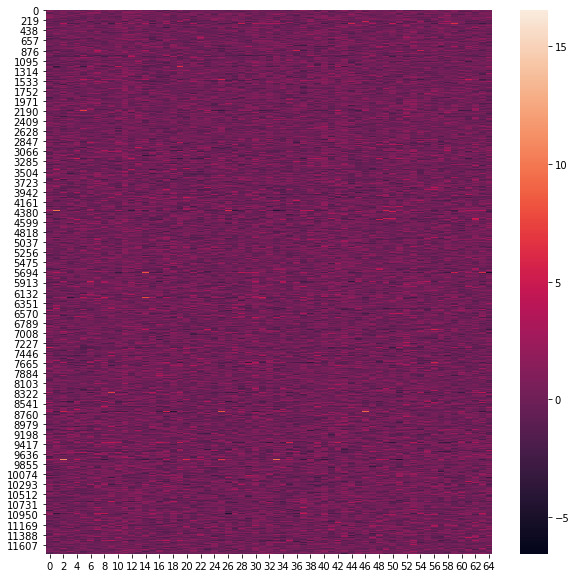

In [26]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [27]:

reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)

pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


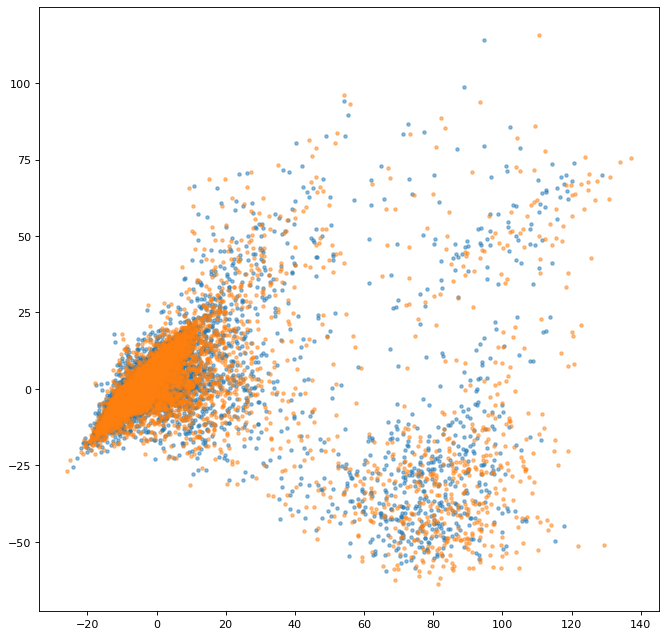

In [28]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)


In [31]:
decoder = L1000_vae.decoder_block["decoder"]


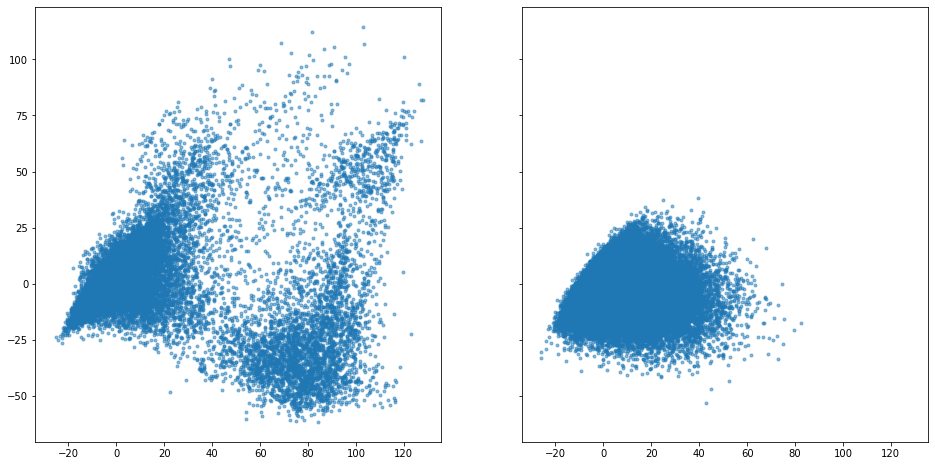

In [32]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(94440, 65)), columns=np.arange(0,65))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [33]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

196.78746248872554

In [34]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latentTwoLayer_vanilla_leaveOut.csv")

In [37]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save('./models/L1000twolayerDecoder_vanilla_leaveOut')

INFO:tensorflow:Assets written to: ./L1000twolayerDecoder_vanilla_leaveOut/assets


In [38]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
encoder.save('./models/L1000twolayerEncoder_vanilla_leaveOut')

INFO:tensorflow:Assets written to: ./L1000twolayerEncoder_vanilla_leaveOut/assets
